# **Amazon Reviews Dataset**

In [1]:
from pprint import pprint

import delta_sharing
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd

In [2]:
%%time
# get data
profile_file = "config.share"
client = delta_sharing.SharingClient(profile_file)
print("Available tables:")
pprint(client.list_all_tables())

table_url = profile_file + "#share__products.silver.amazon_reviews"
# limit number of reviews to 10k
data = delta_sharing.load_as_pandas(table_url, limit=1_000_000)
# cast date column to datetime type
data["date"] = pd.to_datetime(data["date"])

Available tables:
[Table(name='amazon_reviews', share='share__products', schema='silver'),
 Table(name='sample_amazon_metadata', share='share__products', schema='bronze')]
CPU times: user 5.56 s, sys: 2.57 s, total: 8.13 s
Wall time: 20.8 s


In [3]:
print("Dataset shape", data.shape)

data.head()

Dataset shape (1000000, 11)


,asin,image,overall,reviewText,reviewerID,reviewerName,summary,date,verified,vote,source
0,B00005QDPX,None,5,Crazy Taxi is by far one of the best video gam...,A36TDX8DY2XK5Q,Some Kid,It's Party Time! Let's Have Some Fun!,2003-05-30,False,NaN,batch
1,B000MXIMKK,None,4,I love these pants!\n\nFor those of us who sla...,AZZ1YPRM2FAUH,David Colgrove,"Durable, good looking slacks at a reasonable p...",2016-04-06,True,6.0,batch
2,B00005QDPX,None,2,Anyone who hasn't played this game should rent...,A3PASG15BRR40D,SleepyJD,A fun game that gets old too quickly,2003-04-04,False,NaN,batch
3,B000MXIMKK,None,5,Great pants and nice crease.,A388UHKJN07JJT,TJK,Great Product,2016-04-06,True,NaN,batch
4,B00005QDPX,None,4,In this game you choose a driver and car then ...,A29YLR71A42A3N,Amazon Customer,Fun and Entertaining,2002-12-26,False,3.0,batch


In [4]:
# print some reviews
def print_reviews(df, n=3):
    for idx, row in data.sample(n).iterrows():
        print("Review Summary:", row["summary"], "\n")
        print(row["reviewText"])
        print("=" * 50)


print_reviews(data)

Review Summary: Excellent self-study book! 

This book really help me, is easy to understand and all the grammar is very well explained. The CD has a really good content and helps you to continue developing the knowledge you get from the book.
Review Summary: Four Stars 

kool art, and is solid wood with quality feel to it..
Review Summary: Four Stars 

Great item!


**Insights**:
    
- **Build a model that identifies whether a review contains text that is useful**
    - ¿What is a good definition for a useful review?

---

In [5]:
# unique values of asin column
asin_vals = data["asin"].value_counts()
asin_vals

asin
B00GKOMC3S    8561
0553418025    5587
B000MXQ2CU    5475
B000MXIMKK    3452
B000N3Q6S4    3218
              ... 
0553527428       1
B00XDEDQVK       1
B00005QDPW       1
0523002106       1
B00WG7VQYE       1
Name: count, Length: 114550, dtype: int64

In [6]:
asin_vals.describe().astype(int)

count    114550
mean          8
std          57
min           1
25%           1
50%           3
75%           9
max        8561
Name: count, dtype: int64

**Insights**
- Products range from having 1 to a few thousand reviews.
- Most of the products have 8 or less reviews.

In [7]:
fixed_product = data[data["asin"] == asin_vals.index[0]].head()
fixed_product.head()

,asin,image,overall,reviewText,reviewerID,reviewerName,summary,date,verified,vote,source
326875,B00GKOMC3S,None,4,i was satisfied with the product,A1LV8A64Q4RJKH,Naomi Hector,i choose the wrong size,2014-10-30,True,NaN,batch
326877,B00GKOMC3S,None,5,I have enjoyed my red converse for along time ...,AZKO94G1OOPK2,Noella,Love my purple converse!,2014-10-29,False,3.0,batch
326879,B00GKOMC3S,None,3,en el indicador de talla decia que 10 era 42 y...,A2NJEEKB579FOX,Carlos Ochoa,Three Stars,2014-10-29,True,NaN,batch
326881,B00GKOMC3S,None,5,I ordered a 7 and an 8 based off of reviews th...,A1Y0MKZYQIYLQA,E. Phillips,Run TTS!,2014-10-29,True,NaN,batch
326883,B00GKOMC3S,None,5,so cool,A29V963VZXGVP3,Leigh,Five Stars,2014-10-29,False,NaN,batch


In [8]:
print_reviews(fixed_product)

Review Summary: Five Stars 

Thanks
Review Summary: Four Stars 

I like this product; but sometimes, the defect rate is too high, mainly with the hinges.
Review Summary: A thinking person's guide to investing 

Just the information on how the shape of the yield curve influences value and growth stocks alone was worth the price of the book as well as his interpretation of the Presidential Term cycle was fascinating.  I loved the simplicity of the 4 market conditions to know whether to be in stocks or not.  Looking forward to putting his ideas to practice; who knows, maybe some day I'll hire him when I have enough money.


---

In [9]:
duplicated = data[data.duplicated(subset=["asin", "reviewText"], keep=False)].sort_values("reviewText")
duplicated

,asin,image,overall,reviewText,reviewerID,reviewerName,summary,date,verified,vote,source
762733,0345379659,None,4,"""Harlot's Ghost"" is one of the most inconsiste...",A7WH560VVUXB2,Kevin M. Derby,Mailer's Ghost,2009-05-12,False,5.0,batch
762265,0345379659,None,4,"""Harlot's Ghost"" is one of the most inconsiste...",A7WH560VVUXB2,Kevin M. Derby,Mailer's Ghost,2016-08-03,False,4.0,batch
127515,0521547547,None,4,"""The Cambridge Introduction To Creative Writin...",AQJDZ0CW2G7ST,Dr Anup K Das,A book helps in understanding composition and ...,2014-10-05,False,NaN,batch
127513,0521547547,None,4,"""The Cambridge Introduction To Creative Writin...",AQJDZ0CW2G7ST,Dr Anup K Das,A book helps in understanding composition and ...,2014-10-05,False,NaN,batch
127511,0521547547,None,4,"""The Cambridge Introduction To Creative Writin...",AQJDZ0CW2G7ST,Dr Anup K Das,A book helps in understanding composition and ...,2014-10-05,False,NaN,batch
...,...,...,...,...,...,...,...,...,...,...,...
992620,B00XD6AIW8,[https://images-na.ssl-images-amazon.com/image...,5,None,A2076J9VLPG5DB,Amazon Customer,Five Stars,2016-05-07,True,3.0,batch
994460,B00XD8K98Y,None,5,None,A2HEIHSVJ9BLV9,Patty Bonney,Five Stars,2017-09-25,True,NaN,batch
996599,0553524267,None,5,None,A3E9MCUTYBE6ZD,D. Oppenheim,Five Stars,2015-10-14,True,NaN,batch
997009,0553524267,None,5,None,A36H5PVVAXUL3R,Dan Ward,Five Stars,2015-09-27,True,NaN,batch


In [10]:
num_dup = data.duplicated(subset=["asin", "reviewText"], keep="first").sum()
print(f"Percentaje of duplicated reviews {num_dup / len(data) * 100:.2f}%")

Percentaje of duplicated reviews 0.77%


**Insights**

- There is definitively reviews that are exactly the same.
- ~1% of the reviews are duplicated.

---

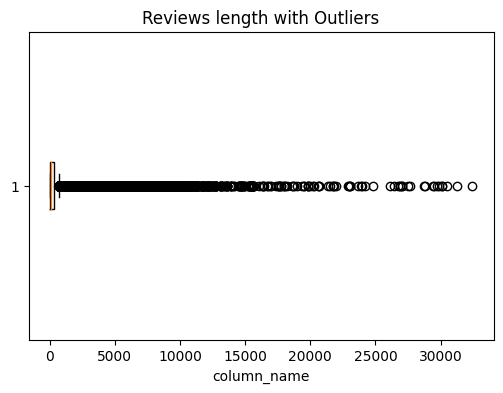

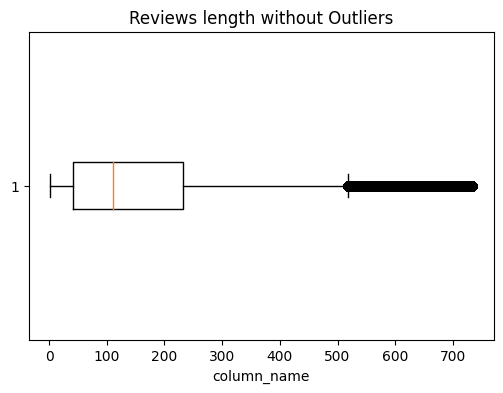

In [11]:
# filter empty reviews
reviews_len = data["reviewText"][~data["reviewText"].isnull()].map(len)

# reviews len with outliers
plt.figure(figsize=(6, 4))
plt.boxplot(reviews_len, vert=False)
plt.title("Reviews length with Outliers")
plt.xlabel("column_name")
plt.show()

Q1 = reviews_len.quantile(0.25)
Q3 = reviews_len.quantile(0.75)
IQR = Q3 - Q1

reviews_no_outliers = reviews_len[(reviews_len >= Q1 - 1.5 * IQR) & (reviews_len <= Q3 + 1.5 * IQR)]

# plot reviews without outliers
plt.figure(figsize=(6, 4))
plt.boxplot(reviews_no_outliers, vert=False)
plt.title("Reviews length without Outliers")
plt.xlabel("column_name")
plt.show()

**Insights**
- There are some reviews with extremely long texts.
- Most reviews have between a couple tens to a couple thousands of characters


---

In [13]:
data["date"].describe()

count                       1000000
mean     2015-03-12 10:42:12.585600
min             1996-12-16 00:00:00
25%             2014-11-24 00:00:00
50%             2016-02-26 00:00:00
75%             2017-05-22 00:00:00
max             2018-09-16 00:00:00
Name: date, dtype: object

---

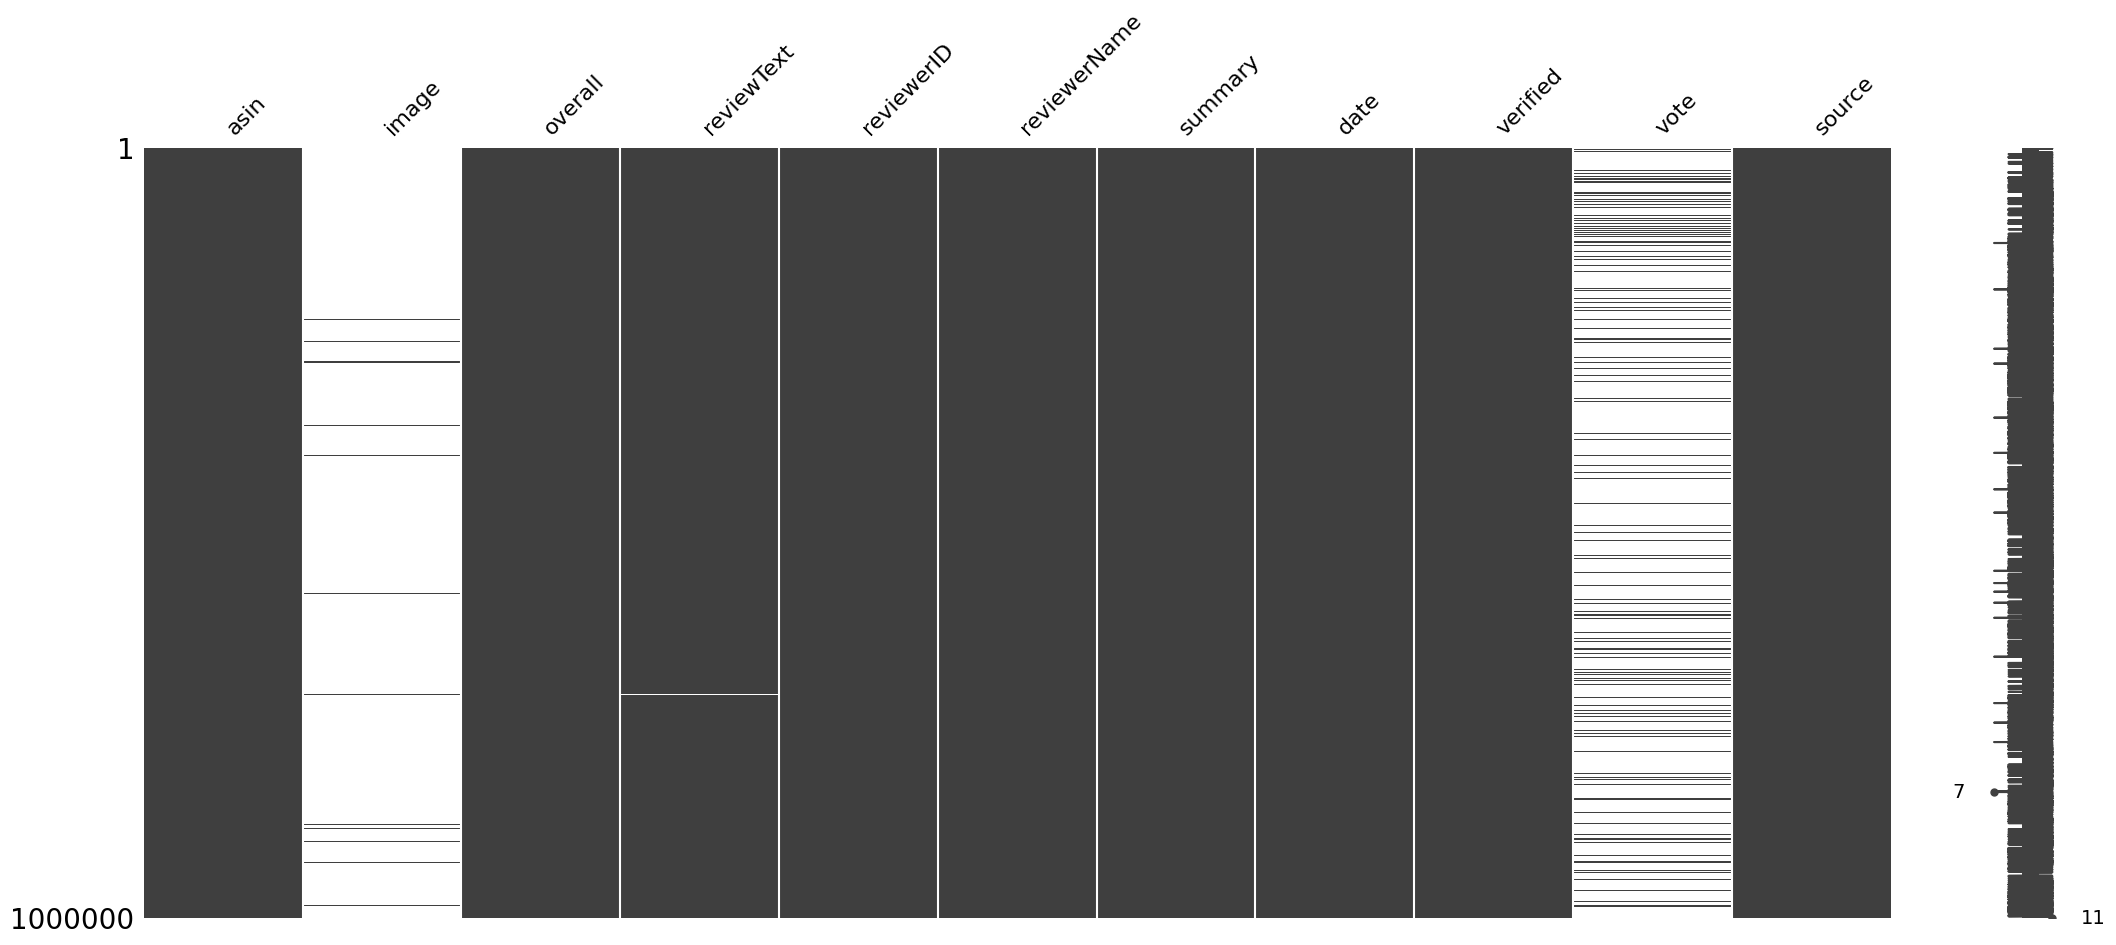

In [14]:
# mising values
msno.matrix(data);

In [15]:
print("Percentaje of missing values:")

data.isnull().sum() / len(data) * 100

Percentaje of missing values:


asin             0.0000
image           98.4755
overall          0.0000
reviewText       0.0820
reviewerID       0.0000
reviewerName     0.0050
summary          0.0462
date             0.0000
verified         0.0000
vote            85.0367
source           0.0000
dtype: float64

**Insights**
- There are reviews with no text. Though we couuld still use the rating information.
- Most reviews don't have images.
- `Vote` column has a lot of missing values.

---

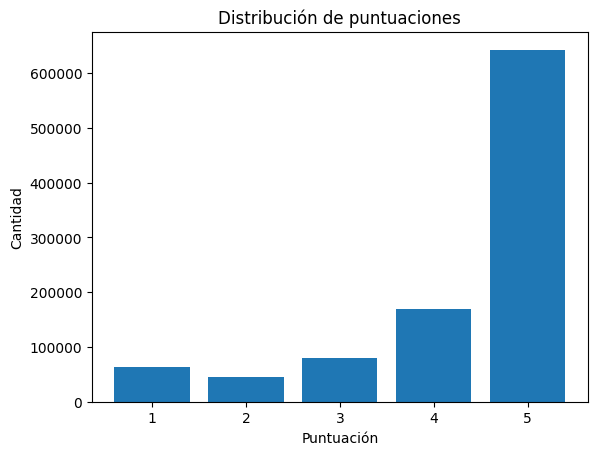

In [16]:
conteo_puntuaciones = data["overall"].value_counts()

plt.bar(conteo_puntuaciones.index, conteo_puntuaciones.values)
plt.xlabel("Puntuación")
plt.ylabel("Cantidad")
plt.title("Distribución de puntuaciones")
plt.xticks(conteo_puntuaciones.index)
plt.show()

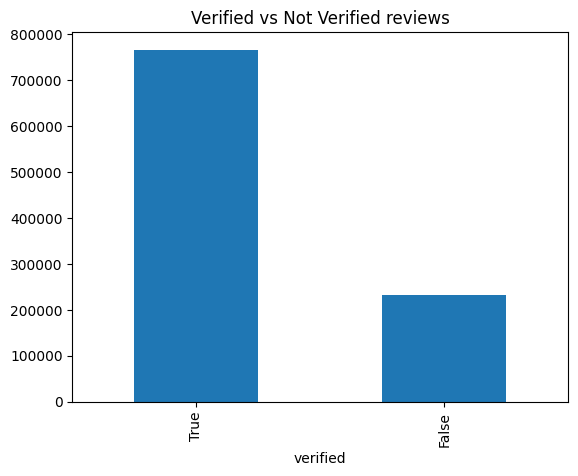

In [17]:
data["verified"].value_counts().plot(kind="bar", title="Verified vs Not Verified reviews");

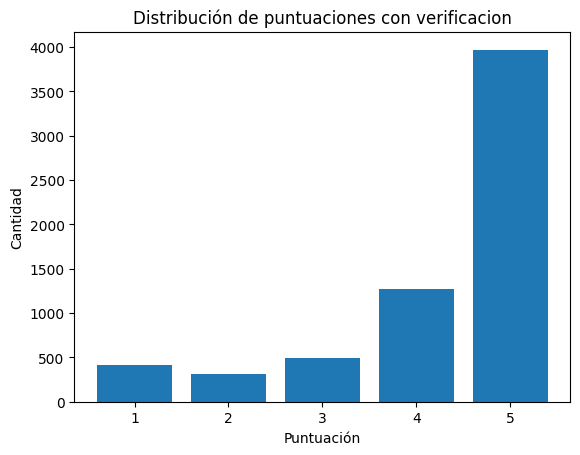

In [117]:
conteo_puntuaciones = data_vtrue["overall"].value_counts()

plt.bar(conteo_puntuaciones.index, conteo_puntuaciones.values)
plt.xlabel("Puntuación")
plt.ylabel("Cantidad")
plt.title("Distribución de puntuaciones con verificacion")
plt.xticks(conteo_puntuaciones.index)
plt.show()

---

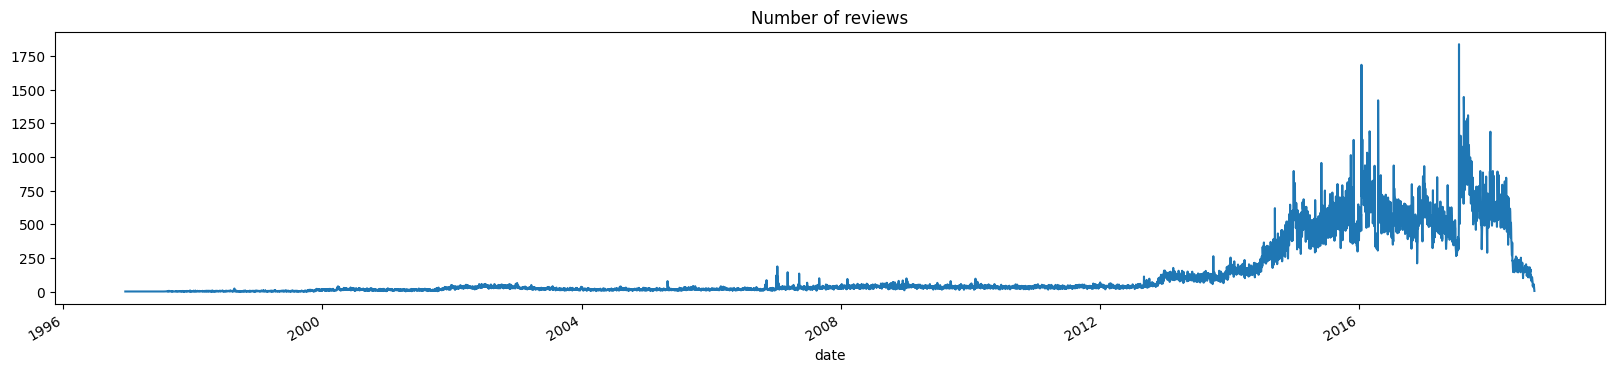

In [18]:
plt.figure(figsize=(20, 4))
data["date"].value_counts().plot(title="Number of reviews");

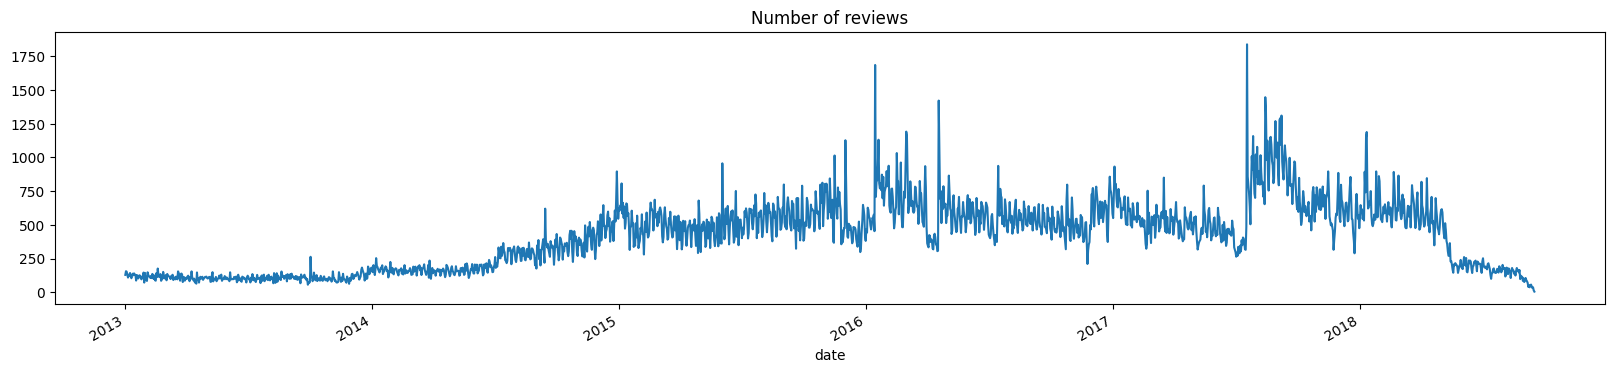

In [22]:
plt.figure(figsize=(20, 4))
data["date"][data["date"].dt.year > 2012].value_counts().plot(title="Number of reviews");

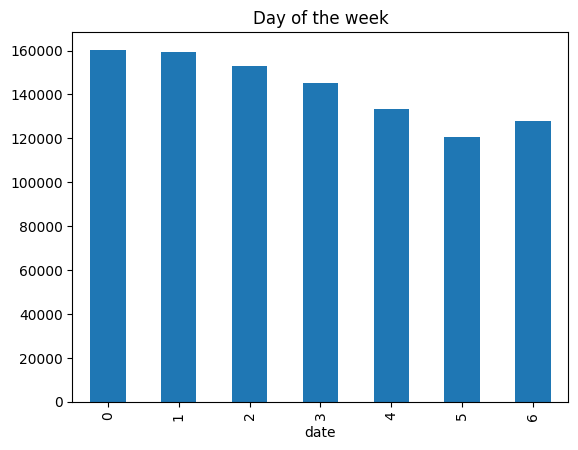

In [23]:
data["date"].dt.weekday.value_counts().sort_index().plot(kind="bar", title="Day of the week");

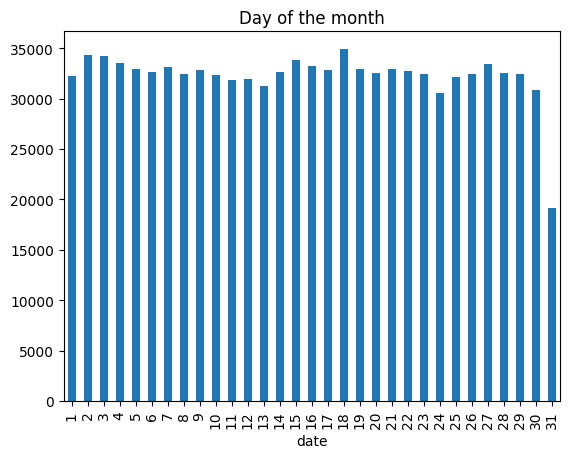

In [24]:
data["date"].dt.day.value_counts().sort_index().plot(kind="bar", title="Day of the month");

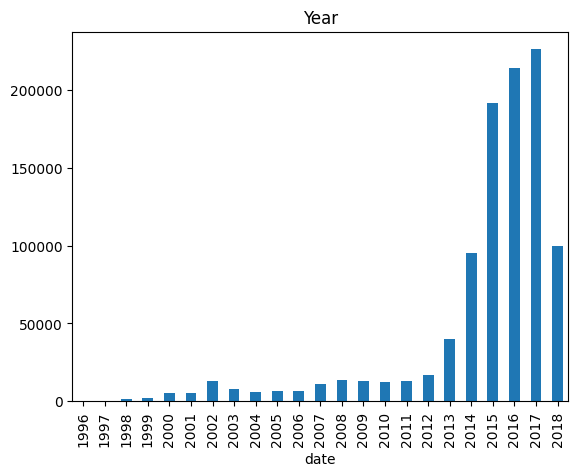

In [25]:
data["date"].dt.year.value_counts().sort_index().plot(kind="bar", title="Year");